In [1]:
import torchaudio
import os
import urllib.request
import tarfile
from torchaudio.datasets import LIBRISPEECH

# Step 1: Download the dataset
def download_librispeech():
    url = "https://www.openslr.org/resources/12/train-clean-100.tar.gz"
    target_path = "./data/librispeech.tar.gz"
    extract_path = "./data/librispeech"

    if not os.path.exists(extract_path):
        print("Downloading LibriSpeech dataset...")
        os.makedirs("./data", exist_ok=True)
        urllib.request.urlretrieve(url, target_path)
        print("Extracting LibriSpeech dataset...")
        with tarfile.open(target_path, 'r:gz') as tar:
            tar.extractall(path="./data")
        print("Dataset ready.")
    else:
        print("Dataset already downloaded.")

# Step 2: Load the dataset
def prepare_dataset():
    dataset_path = "./data/LibriSpeech/train-clean-100"
    if not os.path.exists(dataset_path):
        raise FileNotFoundError("Dataset not found. Run download_librispeech() first.")
    
    print("Loading dataset...")
    dataset = LIBRISPEECH("./data", url="train-clean-100", download=False)
    print(f"Loaded {len(dataset)} samples.")
    return dataset

# Step 3: Preprocess the data
def preprocess_data(dataset, max_samples=100):
    processed_data = []
    print(f"Processing first {max_samples} samples...")
    for i, (waveform, sample_rate, _, _, _, _) in enumerate(dataset):
        if i >= max_samples:
            break
        # Convert waveform to spectrogram
        spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate)(waveform)
        processed_data.append((spectrogram, sample_rate))
    print("Data preprocessing complete.")
    return processed_data

# Execution
if __name__ == "__main__":
    download_librispeech()
    dataset = prepare_dataset()
    processed_data = preprocess_data(dataset)
    print(f"Processed {len(processed_data)} samples into spectrograms.")


KeyboardInterrupt: 

In [2]:
import os
import torch
import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS

# Dataset preparation
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, root, subset: str = None):
        super().__init__(root, download=True)
        if subset:
            self._walker = self._load_list(subset)

    def _load_list(self, subset):
        with open(os.path.join(self._path, f"{subset}_list.txt")) as f:
            return [os.path.join(self._path, line.strip()) for line in f]

# Step 1: Load a small dataset
def prepare_dataset(subset="training"):
    print("Loading SPEECHCOMMANDS dataset...")
    dataset = SubsetSC("./data", subset=subset)
    print(f"Loaded {len(dataset)} samples from {subset} set.")
    return dataset

# Step 2: Preprocess data to extract spectrograms
def preprocess_data(dataset, max_samples=100):
    processed_data = []
    print(f"Processing first {max_samples} samples...")
    for i, (waveform, sample_rate, label, *_rest) in enumerate(dataset):
        if i >= max_samples:
            break
        # Convert waveform to Mel spectrogram
        spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate)(waveform)
        processed_data.append((spectrogram, label))
    print("Data preprocessing complete.")
    return processed_data

# Execution
if __name__ == "__main__":
    # Load and preprocess a small subset
    dataset = prepare_dataset(subset="training")
    processed_data = preprocess_data(dataset, max_samples=50)
    print(f"Processed {len(processed_data)} samples into spectrograms.")
    

Loading SPEECHCOMMANDS dataset...


100%|██████████| 2.26G/2.26G [01:57<00:00, 20.7MB/s]


FileNotFoundError: [Errno 2] No such file or directory: './data\\SpeechCommands\\speech_commands_v0.02\\training_list.txt'

In [4]:
import os
import torchaudio
from torch.utils.data import Dataset

# Custom dataset to load audio files directly
class SpeechCommandsDataset(Dataset):
    def __init__(self, root_dir, max_samples=50):
        self.root_dir = root_dir
        self.max_samples = max_samples
        self.file_paths = []
        self.labels = []
        
        # Load all file paths and labels
        for label in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):
                files = os.listdir(label_path)
                for file in files:
                    if file.endswith('.wav'):
                        self.file_paths.append(os.path.join(label_path, file))
                        self.labels.append(label)
                        # Stop if max samples reached
                        if len(self.file_paths) >= self.max_samples:
                            break
            if len(self.file_paths) >= self.max_samples:
                break

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        waveform, sample_rate = torchaudio.load(file_path)
        return waveform, sample_rate, label

# Initialize the dataset
dataset_root = "data/SpeechCommands/speech_commands_v0.02"  # Path to your data
dataset = SpeechCommandsDataset(dataset_root, max_samples=50)

# Process data into spectrograms
def preprocess_data(dataset):
    processed_data = []
    print(f"Processing {len(dataset)} samples...")
    for waveform, sample_rate, label in dataset:
        # Convert waveform to Mel spectrogram
        spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate)(waveform)
        processed_data.append((spectrogram, label))
    print("Data preprocessing complete.")
    return processed_data

# Execution
processed_data = preprocess_data(dataset)
print(f"Processed {len(processed_data)} samples into spectrograms.")


Processing 50 samples...
Data preprocessing complete.
Processed 50 samples into spectrograms.


c:\Users\msigm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Using device: cuda
Epoch 1/10, Train Loss: 4.6135, Val Loss: 3.5745
Epoch 2/10, Train Loss: 3.4075, Val Loss: 2.2307
Epoch 3/10, Train Loss: 2.0045, Val Loss: 1.0715
Epoch 4/10, Train Loss: 1.0954, Val Loss: 0.5076
Epoch 5/10, Train Loss: 0.5408, Val Loss: 0.2921
Epoch 6/10, Train Loss: 0.3267, Val Loss: 0.1778
Epoch 7/10, Train Loss: 0.1432, Val Loss: 0.0962
Epoch 8/10, Train Loss: 0.0581, Val Loss: 0.0441
Epoch 9/10, Train Loss: 0.0294, Val Loss: 0.0182
Epoch 10/10, Train Loss: 0.0257, Val Loss: 0.0076
Model saved to voice_profile_model.pth


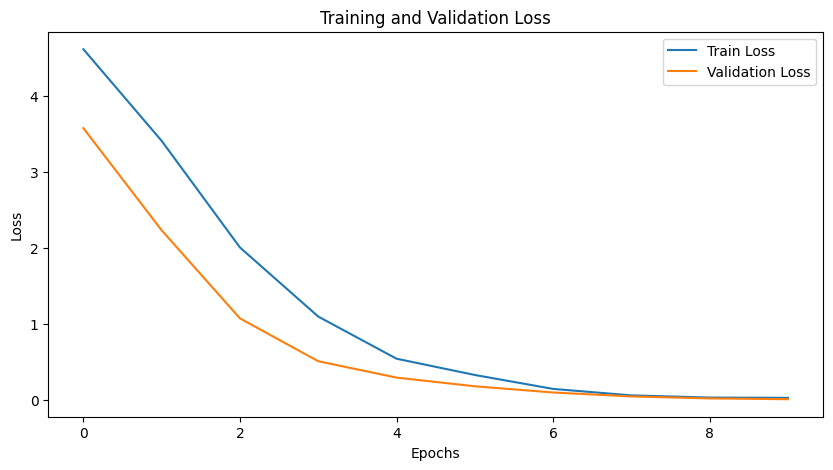

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import torchaudio
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset class
class VoiceProfileDataset(Dataset):
    def __init__(self, data, label_mapping):
        self.data = data
        self.label_mapping = label_mapping  # Map string labels to integers

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        spectrogram, label = self.data[idx]
        label = self.label_mapping[label]  # Convert string label to integer
        return spectrogram, label

# Padding function for variable-length spectrograms
def collate_fn(batch):
    spectrograms = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    # Find max width of spectrograms in the batch
    max_width = max([spec.shape[-1] for spec in spectrograms])

    # Pad spectrograms to the same width
    padded_spectrograms = []
    for spec in spectrograms:
        padding = max_width - spec.shape[-1]
        padded_spec = torch.nn.functional.pad(spec, (0, padding))  # Pad width dimension
        padded_spectrograms.append(padded_spec)

    # Stack into tensor with shape (batch_size, 1, height, width)
    spectrograms_tensor = torch.stack(padded_spectrograms)  # No unsqueeze(1)
    labels_tensor = torch.tensor(labels)

    return spectrograms_tensor, labels_tensor

# Simple CNN model for feature extraction
class VoiceProfileModel(nn.Module):
    def __init__(self):
        super(VoiceProfileModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Placeholder for the size after convolution and pooling
        self.flatten_size = None
        self.fc1 = None
        self.fc2 = nn.Linear(256, 128)  # Embedding for the voice profile

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        # Dynamically set the input size for fc1 during the first forward pass
        if self.flatten_size is None:
            self.flatten_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(self.flatten_size, 256).to(x.device)

        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


# Train the model
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.float().to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.float().to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses

# Save and load functions for the model
def save_model(model, path="voice_profile_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def load_model(model, path="voice_profile_model.pth"):
    model.load_state_dict(torch.load(path))
    model.to(device)
    model.eval()
    print(f"Model loaded from {path}")
    return model

# Plot training and validation losses
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Prepare data and dataloaders
def prepare_dataloader(processed_data, batch_size=16):
    # Create label mapping (string -> integer)
    unique_labels = sorted(set(label for _, label in processed_data))
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

    dataset = VoiceProfileDataset(processed_data, label_mapping)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_loader, val_loader, label_mapping

# Main execution
if __name__ == "__main__":
    # Assuming processed_data is already prepared and contains (spectrogram, label) tuples
    # Example: [(spectrogram1, "label1"), (spectrogram2, "label2"), ...]

    train_loader, val_loader, label_mapping = prepare_dataloader(processed_data)

    # Initialize the model
    model = VoiceProfileModel().to(device)

    # Train the model
    train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=10, lr=0.001)

    # Save the trained model
    save_model(model)

    # Plot the training and validation losses
    plot_losses(train_losses, val_losses)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import torchaudio
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset class
class VoiceProfileDataset(Dataset):
    def __init__(self, data, label_mapping):
        self.data = data
        self.label_mapping = label_mapping  # Map string labels to integers

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        spectrogram, label = self.data[idx]
        label = self.label_mapping[label]  # Convert string label to integer
        return spectrogram, label

# Padding function for variable-length spectrograms

def collate_fn(batch):
    spectrograms = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    # Find max width of spectrograms in the batch
    max_width = max([spec.shape[-1] for spec in spectrograms])

    # Pad spectrograms to the same width
    padded_spectrograms = []
    for spec in spectrograms:
        padding = max_width - spec.shape[-1]
        padded_spec = torch.nn.functional.pad(spec, (0, padding))  # Pad width dimension
        padded_spectrograms.append(padded_spec)

    # Stack into tensor with shape (batch_size, 1, height, width)
    spectrograms_tensor = torch.stack(padded_spectrograms)  # Usunięto unsqueeze(1)
    labels_tensor = torch.tensor(labels)

    return spectrograms_tensor, labels_tensor


# Simple CNN model for feature extraction
class VoiceProfileModel(nn.Module):
    def __init__(self):
        super(VoiceProfileModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Placeholder for the size after convolution and pooling
        self.flatten_size = None
        self.fc1 = None
        self.fc2 = nn.Linear(256, 128)  # Embedding for the voice profile

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        # Dynamically set the input size for fc1 during the first forward pass
        if self.flatten_size is None:
            self.flatten_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(self.flatten_size, 256).to(x.device)

        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


# Train the model and compute accuracy
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.float().to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.float().to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, val_accuracies

# Save and load functions for the model
def save_model(model, path="voice_profile_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def load_model(model, path="voice_profile_model.pth"):
    model.load_state_dict(torch.load(path))
    model.to(device)
    model.eval()
    print(f"Model loaded from {path}")
    return model

# Plot training and validation losses and accuracy
def plot_metrics(train_losses, val_losses, val_accuracies):
    plt.figure(figsize=(15, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Prepare data and dataloaders
def prepare_dataloader(processed_data, batch_size=16):
    # Create label mapping (string -> integer)
    unique_labels = sorted(set(label for _, label in processed_data))
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

    dataset = VoiceProfileDataset(processed_data, label_mapping)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_loader, val_loader, label_mapping

# Main execution
if __name__ == "__main__":
    # Assuming processed_data is already prepared and contains (spectrogram, label) tuples
    train_loader, val_loader, label_mapping = prepare_dataloader(processed_data)

    # Initialize the model
    model = VoiceProfileModel().to(device)

    # Train the model
    train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, epochs=10, lr=0.001)

    # Save the trained model
    save_model(model)

    # Plot the training and validation losses and accuracy
    plot_metrics(train_losses, val_losses, val_accuracies)


Using device: cuda


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [16, 1, 1, 128, 81]